### Intasll packages

In [ ]:
!pip3.8 install -U  google.cloud "pandas<2.0.0" google-cloud-storage==2.9.0 mlflow==2.3.1

### Set env variables

In [ ]:
%env IAP_CLIENT_ID="389410459067-mltiuc7631od8mhp9aokhb03qdlj81qp.apps.googleusercontent.com"

### Get OIDC token for authentication to MLflow instance behind Identity-aware Proxy (IaP)

In [ ]:
import os
import subprocess
mlflow_token=subprocess.getoutput("""curl -s -X POST -H "content-type: application/json" -H "Authorization: Bearer $(gcloud auth print-access-token)" -d "{\"audience\": \"${IAP_CLIENT_ID}\", \"includeEmail\": true }" "https://iamcredentials.googleapis.com/v1/projects/-/serviceAccounts/$(gcloud auth list --filter=status:ACTIVE --format='value(account)'):generateIdToken"  | jq -r '.token'""")
os.environ['MLFLOW_TRACKING_TOKEN'] = mlflow_token

In [ ]:
%env MLFLOW_TRACKING_URI=https://mlflow-dot-tbd-2023l-mlops.ew.r.appspot.com/

In [ ]:
%env PYSPARK_PYTHON=/usr/bin/python3.8
%env PYSPARK_DRIVER_PYTHON=/usr/bin/python3.8

### Please specify your student id

In [ ]:
%env STUDENT_ID=2003

### Test connectivity with MLflow tracking server

In [ ]:
%%bash 
mlflow experiments search

### Prepare training data

In [ ]:
%%bash
gsutil mb -l europe-west1 gs://tbd-2023l-${STUDENT_ID}-data

In [ ]:
%%bash
curl -L https://github.com/datascienceverse/stack-overflow-dataset-2022/raw/master/survey_results_public.csv | gsutil cp - gs://tbd-2023l-${STUDENT_ID}-data/survey_results_public.csv

In [ ]:
%%bash
gsutil du -h gs://tbd-2023l-${STUDENT_ID}-data/survey_results_public.csv

### GCS connector

In [ ]:
%%bash
wget https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.9/gcs-connector-hadoop3-2.2.9-shaded.jar

### Spark session

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.master('yarn') \
.config('spark.executor.instance',2) \
.config('spark.jars','gcs-connector-hadoop3-2.2.9-shaded.jar') \
.config('spark.jars.packages','org.mlflow:mlflow-spark:1.11.0') \
.config('spark.executorEnv.PYSPARK_PYTHON','/usr/bin/python3.8') \
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

### Establish a proxy for accessing Hadoop Web UIs including YARN and Apache spark
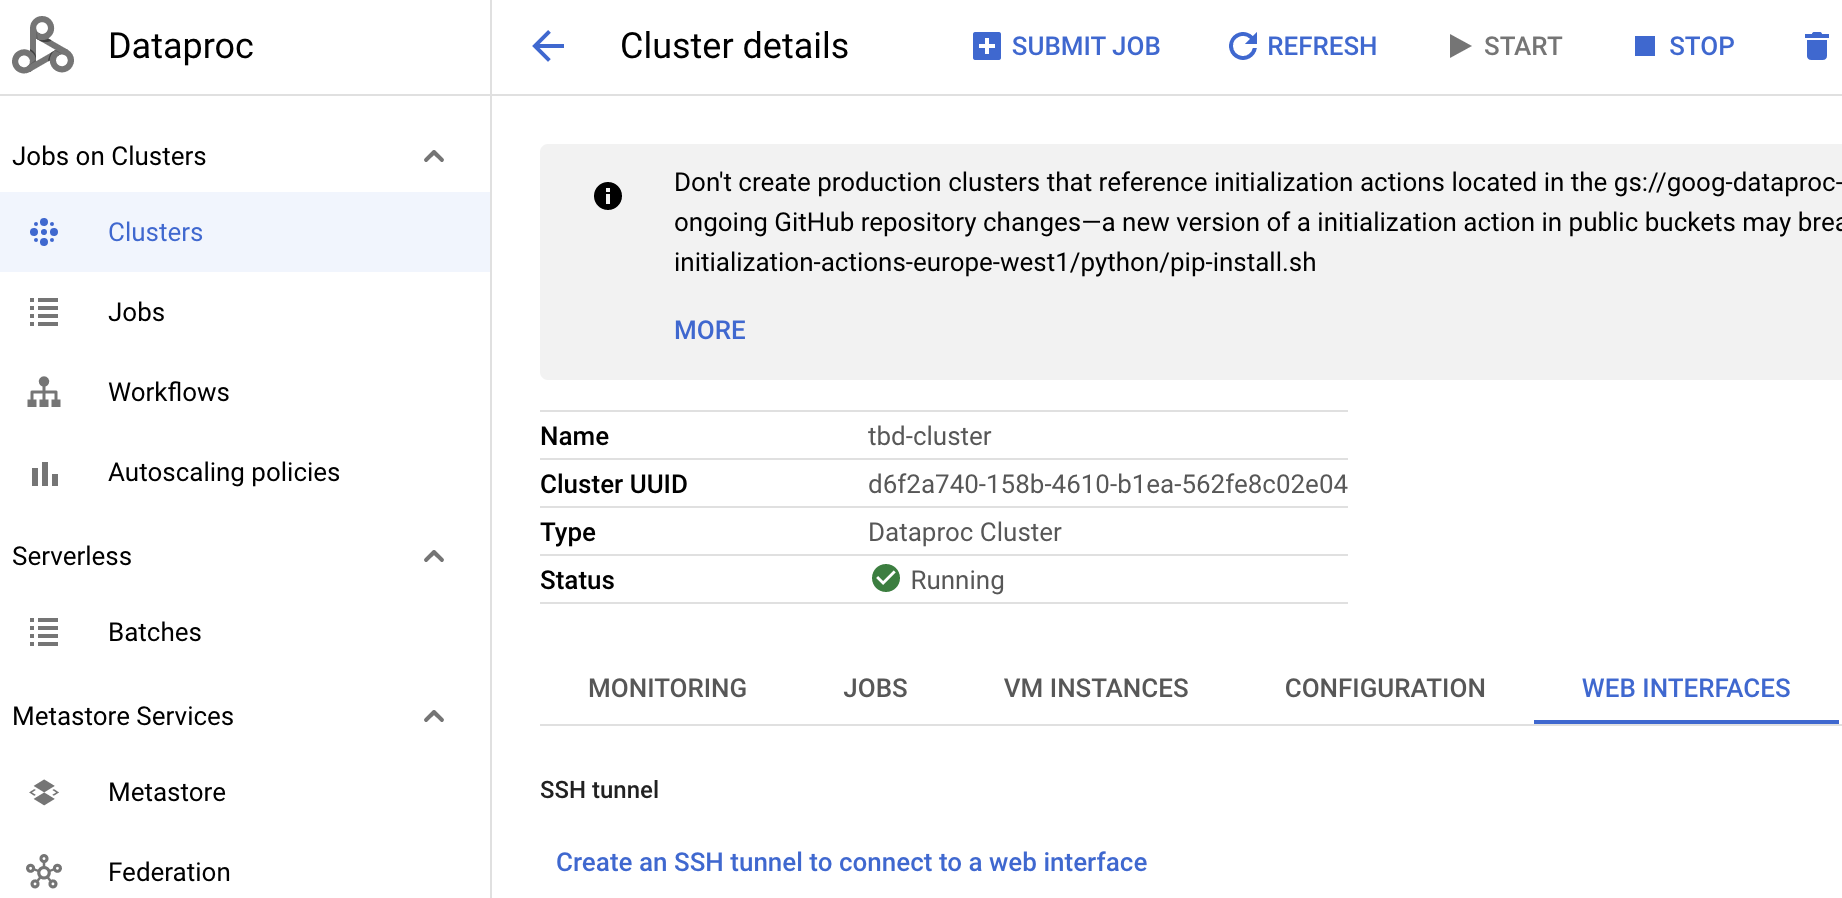

In [18]:
import os
db_name = "tbd"
student_id = os.environ['STUDENT_ID']
gs_path = f"gs://tbd-2023l-{student_id}-data/survey_results_public.csv"
spark.sql(f'DROP DATABASE IF EXISTS {db_name} CASCADE')
spark.sql(f'CREATE DATABASE {db_name}')
spark.sql(f'USE {db_name}')
table_name = "survey_2022" 

spark.sql(f'DROP TABLE IF EXISTS {table_name}')

spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{gs_path}"')

spark_df= spark.sql(f'SELECT *, CAST((ConvertedCompYearly > 60000) AS STRING) AS compAboveAvg \
                    FROM {table_name} WHERE ConvertedCompYearly IS NOT NULL ')

In [19]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
y = 'compAboveAvg' 
feature_columns = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'YearsCode']

stringindexer_stages = [StringIndexer(inputCol=c, outputCol='strindexed_' + c).setHandleInvalid("keep") for c in feature_columns]
stringindexer_stages += [StringIndexer(inputCol=y, outputCol='label').setHandleInvalid("keep")]

onehotencoder_stages = [OneHotEncoder(inputCol='strindexed_' + c, outputCol='onehot_' + c) for c in feature_columns]
extracted_columns = ['onehot_' + c for c in feature_columns]
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features') 

final_columns = [y] + feature_columns + extracted_columns + ['features', 'label']

transformed_df = Pipeline(stages=stringindexer_stages + \
                          onehotencoder_stages + \
                          [vectorassembler_stage]).fit(spark_df).transform(spark_df).select(final_columns)
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234) # Podzial na zbior treningowy/testowy

### Set the experiment that we would like to use for tracking training runs

In [20]:
import mlflow   
import mlflow.spark

ename = f"tbd-2023l-{student_id}"
artifacts_location= "artifacts"
mlflow.set_experiment(experiment_name=ename)
experiment = mlflow.get_experiment_by_name(ename)
experiment

### Prepare metrics that we would like to log

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
evaluator_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_f = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedFMeasure")

### Start a training using the decision tree model

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier

with mlflow.start_run(experiment_id = experiment.experiment_id):
    mlflow.log_param('model_type', 'DecisionTreeClassifier')
    dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
    mlflow.set_tag("classifier", "decision_tree")  ## ustawienie tagow
    mlflow.log_param("depth", dt.getMaxDepth())    ## zapisanie metadanych - hiperparametrow

    dt_model = Pipeline(stages=[dt]).fit(training)
    pred_dt = dt_model.transform(test)
    label_and_pred = pred_dt.select('label', 'prediction')
    res = dt_model.transform(test)

    test_metric_acc = evaluator_acc.evaluate(res)
    test_metric_recall = evaluator_recall.evaluate(res)
    test_metric_prec = evaluator_prec.evaluate(res)
    test_metric_f = evaluator_f.evaluate(res)

    mlflow.log_metric(evaluator_acc.getMetricName(), test_metric_acc) 
    mlflow.log_metric(evaluator_recall.getMetricName(), test_metric_recall) 
    mlflow.log_metric(evaluator_prec.getMetricName(), test_metric_prec)     
    mlflow.log_metric(evaluator_f.getMetricName(), test_metric_f)
    mlflow.spark.log_model(dt_model, artifact_path=artifacts_location)

### Start a training using the gradient boost trees model

In [23]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(training)

with mlflow.start_run(experiment_id = experiment.experiment_id):
    mlflow.log_param('model_type', 'GBTClassifier')
    mlflow.log_param("depth", gbt.getMaxDepth())
    res = gbt_model.transform(test)
    test_metric_acc = evaluator_acc.evaluate(res)
    test_metric_recall = evaluator_recall.evaluate(res)
    test_metric_prec = evaluator_prec.evaluate(res)
    test_metric_f = evaluator_f.evaluate(res)

    mlflow.log_metric(evaluator_acc.getMetricName(), test_metric_acc) 
    mlflow.log_metric(evaluator_recall.getMetricName(), test_metric_recall) 
    mlflow.log_metric(evaluator_prec.getMetricName(), test_metric_prec)     
    mlflow.log_metric(evaluator_f.getMetricName(), test_metric_f) 
  
    mlflow.spark.log_model(spark_model=gbt_model, artifact_path='gbt_classifier') 

### Run predictions

In [24]:
import mlflow
logged_model = 'runs:/83b4e502895840719d976337812b0d3b/artifacts'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(test.limit(10).toPandas()))

In [25]:
spark.stop()